<a href="https://colab.research.google.com/github/Carlos1729/Transformers_Code/blob/main/Data_Preperation_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.8 MB/s eta 0:00:00


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.3
    Uninstalling huggingface-hub-0.19.3:
      Successfully uninstalled huggingface-hub-0.19.3


In [3]:
import pandas as pd
import datasets

from pprint import pprint
from transformers import AutoTokenizer

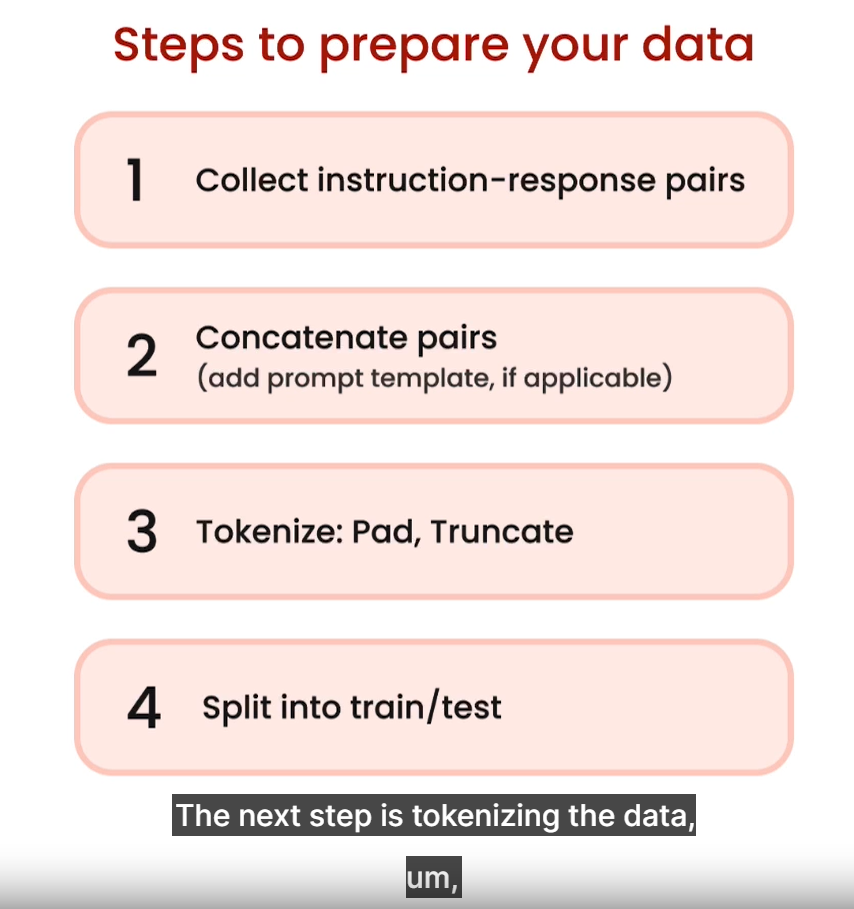

In [4]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")

In [5]:
text = "Hi, how are you?"

In [6]:
#Auto tokenizer finds the already used tokenizer that is used while training that model by default

In [7]:
encoded_text = tokenizer(text)['input_ids']

In [8]:
encoded_text

[12764, 13, 849, 403, 368, 32]

In [9]:
decoded_text = tokenizer.decode(encoded_text)
print("Decoded tokens back into text: ", decoded_text)

Decoded tokens back into text:  Hi, how are you?


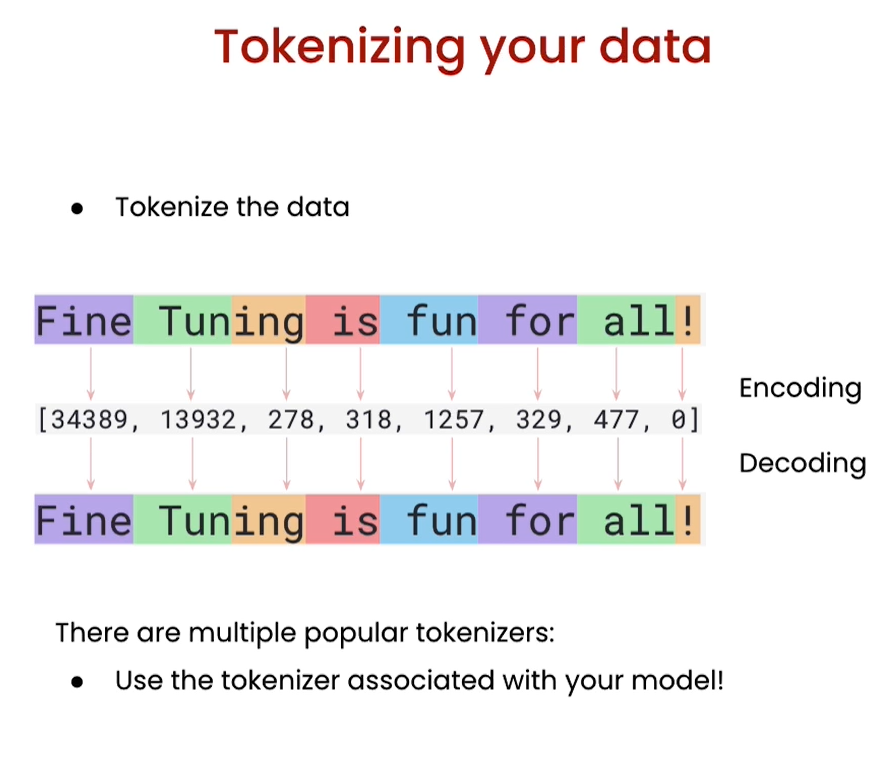

### Tokenize multiple texts at once

In [10]:
list_texts = ["Hi, how are you?", "I'm good", "Yes"]
encoded_texts = tokenizer(list_texts)
print("Encoded several texts: ", encoded_texts["input_ids"])

Encoded several texts:  [[12764, 13, 849, 403, 368, 32], [42, 1353, 1175], [4374]]


### Padding and truncation

In [11]:
tokenizer.pad_token = tokenizer.eos_token#eos token is 0
encoded_texts_longest = tokenizer(list_texts, padding=True)
print("Using padding: ", encoded_texts_longest["input_ids"])#padding is  added to make all strings of same length so that training becomes easy

Using padding:  [[12764, 13, 849, 403, 368, 32], [42, 1353, 1175, 0, 0, 0], [4374, 0, 0, 0, 0, 0]]


In [12]:
encoded_texts_truncation = tokenizer(list_texts, max_length=3, truncation=True)#trunctating all tokens to a given size
print("Using truncation: ", encoded_texts_truncation["input_ids"])

Using truncation:  [[12764, 13, 849], [42, 1353, 1175], [4374]]


In [13]:
tokenizer.truncation_side = "left"#some times we need at the end then we can do this basically trunctaing last 3
encoded_texts_truncation_left = tokenizer(list_texts, max_length=3, truncation=True)
print("Using left-side truncation: ", encoded_texts_truncation_left["input_ids"])

Using left-side truncation:  [[403, 368, 32], [42, 1353, 1175], [4374]]


In [14]:
encoded_texts_both = tokenizer(list_texts, max_length=3, truncation=True, padding=True)
print("Using both padding and truncation: ", encoded_texts_both["input_ids"])

Using both padding and truncation:  [[403, 368, 32], [42, 1353, 1175], [4374, 0, 0]]


{0: {0: 'train'}}

In [18]:
import pandas as pd

filename = "lamini_docs.jsonl"
instruction_dataset_df = pd.read_json(filename, lines=True)
examples = instruction_dataset_df.to_dict()

if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  text = examples["text"][0]
  print(text)

prompt_template = """### Question:
{question}

### Answer:"""

num_examples = len(examples["question"])
finetuning_dataset = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]
  text_with_prompt_template = prompt_template.format(question=question)
  finetuning_dataset.append({"question": text_with_prompt_template, "answer": answer})

from pprint import pprint
print("One datapoint in the finetuning dataset:")
pprint(finetuning_dataset[0])

One datapoint in the finetuning dataset:
{'answer': 'Lamini has documentation on Getting Started, Authentication, '
           'Question Answer Model, Python Library, Batching, Error Handling, '
           'Advanced topics, and class documentation on LLM Engine available '
           'at https://lamini-ai.github.io/.',
 'question': '### Question:\n'
             'What are the different types of documents available in the '
             'repository (e.g., installation guide, API documentation, '
             "developer's guide)?\n"
             '\n'
             '### Answer:'}


In [19]:
text = finetuning_dataset[0]["question"] + finetuning_dataset[0]["answer"]
tokenized_inputs = tokenizer(
    text,
    return_tensors="np",
    padding=True
)
print(tokenized_inputs["input_ids"])

[[ 4118 19782    27   187  1276   403   253  1027  3510   273  7177  2130
    275   253 18491   313    70    15    72   904 12692  7102    13  8990
  10097    13 13722   434  7102  6177   187   187  4118 37741    27    45
   4988    74   556 10097   327 27669 11075   264    13  5271 23058    13
  19782 37741 10031    13 13814 11397    13   378 16464    13 11759 10535
   1981    13 21798 12989    13   285   966 10097   327 21708    46 10797
   2130   387  5987  1358    77  4988    74    14  2284    15  7280    15
    900 14206]]


In [22]:
max_length = 2048
max_length = min(
    tokenized_inputs["input_ids"].shape[1],
    max_length,
)

In [23]:
tokenized_inputs = tokenizer(
    text,
    return_tensors="np",
    truncation=True,
    max_length=max_length
)

In [24]:
tokenized_inputs["input_ids"]

array([[ 4118, 19782,    27,   187,  1276,   403,   253,  1027,  3510,
          273,  7177,  2130,   275,   253, 18491,   313,    70,    15,
           72,   904, 12692,  7102,    13,  8990, 10097,    13, 13722,
          434,  7102,  6177,   187,   187,  4118, 37741,    27,    45,
         4988,    74,   556, 10097,   327, 27669, 11075,   264,    13,
         5271, 23058,    13, 19782, 37741, 10031,    13, 13814, 11397,
           13,   378, 16464,    13, 11759, 10535,  1981,    13, 21798,
        12989,    13,   285,   966, 10097,   327, 21708,    46, 10797,
         2130,   387,  5987,  1358,    77,  4988,    74,    14,  2284,
           15,  7280,    15,   900, 14206]])

### Tokenize the instruction dataset

In [25]:
def tokenize_function(examples):
    if "question" in examples and "answer" in examples:
      text = examples["question"][0] + examples["answer"][0]
    elif "input" in examples and "output" in examples:
      text = examples["input"][0] + examples["output"][0]
    else:
      text = examples["text"][0]

    tokenizer.pad_token = tokenizer.eos_token
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        padding=True,
    )

    max_length = min(
        tokenized_inputs["input_ids"].shape[1],
        2048
    )
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=max_length
    )

    return tokenized_inputs

In [27]:
finetuning_dataset_loaded = datasets.load_dataset("json", data_files="lamini_docs.jsonl", split="train")

tokenized_dataset = finetuning_dataset_loaded.map(
    tokenize_function,
    batched=True,
    batch_size=1,
    drop_last_batch=True
)

print(tokenized_dataset)

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 1400
})


In [28]:
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

In [29]:
tokenized_dataset

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1400
})

In [30]:
dstopd = tokenized_dataset.to_pandas()

In [31]:
dstopd

,question,answer,input_ids,attention_mask,labels
0,What are the different types of documents avai...,"Lamini has documentation on Getting Started, A...","[1276, 403, 253, 1027, 3510, 273, 7177, 2130, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1276, 403, 253, 1027, 3510, 273, 7177, 2130, ..."
1,What is the recommended way to set up and conf...,Lamini can be downloaded as a python package a...,"[1276, 310, 253, 8521, 1039, 281, 873, 598, 28...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1276, 310, 253, 8521, 1039, 281, 873, 598, 28..."
2,How can I find the specific documentation I ne...,"You can ask this model about documentation, wh...","[2347, 476, 309, 1089, 253, 2173, 10097, 309, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2347, 476, 309, 1089, 253, 2173, 10097, 309, ..."
3,Does the documentation include explanations of...,Our documentation provides both real-world and...,"[10795, 253, 10097, 2486, 22909, 273, 253, 212...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10795, 253, 10097, 2486, 22909, 273, 253, 212..."
4,Does the documentation provide information abo...,External dependencies and libraries are all av...,"[10795, 253, 10097, 2085, 1491, 670, 667, 6024...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10795, 253, 10097, 2085, 1491, 670, 667, 6024..."
...,...,...,...,...,...
1395,What is Lamini and what is its collaboration w...,Lamini is a library that simplifies the proces...,"[1276, 310, 418, 4988, 74, 285, 752, 310, 697,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1276, 310, 418, 4988, 74, 285, 752, 310, 697,..."
1396,How does Lamini simplify the process of access...,Lamini simplifies data access in Databricks by...,"[2347, 1057, 418, 4988, 74, 25636, 253, 1232, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2347, 1057, 418, 4988, 74, 25636, 253, 1232, ..."
1397,What are some of the key features provided by ...,Lamini automatically manages the infrastructur...,"[1276, 403, 690, 273, 253, 2234, 3386, 2530, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1276, 403, 690, 273, 253, 2234, 3386, 2530, 4..."
1398,How does Lamini ensure data privacy during the...,"During the training process, Lamini ensures da...","[2347, 1057, 418, 4988, 74, 5416, 941, 11068, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2347, 1057, 418, 4988, 74, 5416, 941, 11068, ..."


In [32]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, shuffle=True, seed=123)
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})
